<a href="https://colab.research.google.com/github/saeedzou/Deep-Learning-Project/blob/dev-saeed/Phase%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Student Names : 
# Saeedreza Zouahkiani, Masoud Rahimi, Ehsanollah Shourezari

In [ ]:
# This block downloads and preprocesses the needed data for the project
!git clone https://github.com/XL2248/MSCTD
!cp MSCTD/MSCTD_data/ende/eng* .
!cp MSCTD/MSCTD_data/ende/ima* .
!cp MSCTD/MSCTD_data/ende/sent* .
!rm -rf MSCTD
!mkdir train
!mkdir dev
!mkdir test
!mv *train.txt train
!mv *dev.txt dev
!mv *test.txt test

Cloning into 'MSCTD'...
remote: Enumerating objects: 1217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1217 (delta 13), reused 7 (delta 3), pack-reused 1190
Receiving objects: 100% (1217/1217), 102.24 MiB | 14.10 MiB/s, done.
Resolving deltas: 100% (616/616), done.
Updating files: 100% (934/934), done.


In [ ]:
import numpy as np
import pandas as pd
import nltk
import nltk.tokenize as tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
import string
import re
import gc
import random
import matplotlib.pyplot as plt
!pip install -q transformers
import seaborn as sns
from transformers import BertTokenizer
from transformers import BertModel

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
class MSCTD(Dataset):
    """
    :param root: root path of the dataset
    :param split: train, dev, test
    :param image_transform: transform for image
    :param text_transform: transform for text
    :param sentiment_transform: transform for sentiment
    :param has_data: dict, whether the dataset has image, text
    :param text_path: path of the text file
    :param image_path: path of the image folder
    :param sentiment_path: path of the sentiment file
    :param image_index_path: path of the image index file

    :return: combination of image, sentiment, text, image_index

    Example:
    >>> from torchvision import transforms
    >>> image_transform = transforms.Compose([
    >>>     transforms.Resize((640, 1280)),
    >>>     transforms.Lambda(lambda x: x.permute(1, 2, 0))
    >>> ])
    >>> text_transform = None
    >>> sentiment_transform = None
    >>> dataset = MSCTD(root='data', split='train', image_transform=image_transform,
    >>>                 text_transform=text_transform, sentiment_transform=sentiment_transform)
    >>> image, text, sentiment = dataset[0]

    """
    def __init__(self, root, split, image_transform=None, text_transform=None, sentiment_transform=None,
                 has_data={'image': True, 'text': True}, text_path=None, image_path=None, sentiment_path=None,
                 image_index_path=None):
        data_path = os.path.join(root, split)
        default_path = {
            'text': os.path.join(data_path, 'english_' + split + '.txt'),
            'image': os.path.join(data_path, 'image'),
            'sentiment': os.path.join(data_path, 'sentiment_' + split + '.txt'),
            'image_index': os.path.join(data_path, 'image_index_' + split + '.txt'),
        }
        self.image = [] if has_data['image'] else None
        self.image_transform = image_transform
        self.image_path = image_path if image_path else default_path['image']
        self.text = [] if has_data['text'] else None
        self.text_transform = text_transform
        self.text_path = text_path if text_path else default_path['text']
        self.sentiment_path = sentiment_path if sentiment_path else default_path['sentiment']
        self.image_index_path = image_index_path if image_index_path else default_path['image_index']
        self.sentiment = []
        self.image_index = []
        self.sentiment_transform = sentiment_transform
        self.load_data()
        
    def load_data(self):
        self.sentiment = np.loadtxt(self.sentiment_path, dtype=int)
        if self.text is not None:
            with open(self.text_path, 'r') as f:
                self.text = f.readlines()
            self.text = [x.strip() for x in self.text]
        with open(self.image_index_path, 'r') as f:
            data = f.readlines()
        self.image_index = [list(map(int, x[1:-2].split(','))) for x in data]

    def __getitem__(self, index):
        image = None
        text = None
        sentiment = self.sentiment[index]
        if self.image is not None:
            imag_path = os.path.join(self.image_path, str(index)+'.jpg')
            image = read_image(imag_path)
            if self.image_transform:
                image = self.image_transform(image)
        if self.text is not None:
            text = self.text[index]
            if self.text_transform:
                text = self.text_transform(text)
        if self.sentiment_transform:
            sentiment = self.sentiment_transform(sentiment)
        if text is not None and image is not None:
            return image, text, sentiment
        elif text is not None:
            return text, sentiment
        elif image is not None:
            return image, sentiment
        else:
            raise Exception('Either image or text should be not None')

    def __len__(self):
        return len(self.sentiment)

In [ ]:
MSCTD_train = MSCTD(root='.', split='train', has_data={'image': False, 'text': True})
MSCTD_dev = MSCTD(root='.', split='dev', has_data={'image': False, 'text': True})
MSCTD_test = MSCTD(root='.', split='test', has_data={'image': False, 'text': True})

In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to first character used by WordNetLemmatizer"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def text_preprocessor(dataset):
      # preprocess text
      dataset.text = [preprocess_text(text) for text in dataset.text]

def preprocess_text(text):
      # Replace contractions with original text
  text = re.sub(r'(\b[Aa]in\'t\b)', "am not", text)
  text = re.sub(r'(\b[Hh]a\'t\b)', "has", text)
  text = re.sub(r'(\b[Ii]\'m\b)', "i am", text)
  text = re.sub(r'(\b\'s\b)', " is", text)
  text = re.sub(r'(\b\'re\b)', " are", text)
  text = re.sub(r'(\b\'ve\b)', " have", text)
  text = re.sub(r'(\b\'d\b)', " would", text)
  text = re.sub(r'(\b\'ll\b)', " will", text)
  text = re.sub(r'(\b[Ss]han\'t\b)', "shall not", text)
  text = re.sub(r'(\b[Ww]on\'t\b)', "will not", text)
  text = re.sub(r'(\b[Ww]ouldn\'t\b)', "would not", text)
  text = re.sub(r'(\b[Dd]on\'t\b)', "do not", text)
  text = re.sub(r'(\b[Cc]an\'t\b)', "can not", text)
  text = re.sub(r'(\b[Ii]s\'nt\b)', "is not", text)
  text = re.sub(r'(\b[Ww]eren\'t\b)', "were not", text)
  text = re.sub(r'(\b[Hh]aven\'t\b)', "have not", text)
  text = re.sub(r'(\b[Hh]adn\'t\b)', "had not", text)
  text = re.sub(r'(\b[Hh]asn\'t\b)', "has not", text)
  text = re.sub(r'(\b[Hh]adn\'t\b)', "had not", text)
  text = re.sub(r'(\b[Dd]idn\'t\b)', "did not", text)

  # Remove punctuation
  text = text.translate(str.maketrans("", "", string.punctuation))

  # Convert to lowercase
  text = text.lower()

  # Tokenize text
  tokens = word_tokenize(text)

  # Remove stop words
  # tokens = [token for token in tokens if token not in stop_words]
  # Remove numbers
  tokens = [token for token in tokens if token.isalpha()]

  # Lemmatize tokens
  tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

  return ' '.join(tokens)

# Test the TextPreprocessor
text_preprocessor(MSCTD_train)
text_preprocessor(MSCTD_dev)
text_preprocessor(MSCTD_test)

# TF-IDF Method

In [ ]:
class TFIDFProcessor:
    def __init__(self, dataset):
        self.dataset = dataset
        self.tfidf = TfidfVectorizer()
        self.tfidf_matrix = None

    def fit(self):
        # Get all the captions from the dataset
        captions = [caption for caption, _ in self.dataset]

        # Fit the TF-IDF model on the captions
        self.tfidf_matrix = self.tfidf.fit_transform(captions)

    def transform(self, caption):
        # Transform the input caption using the fitted TF-IDF model
        tfidf_vector = self.tfidf.transform([caption])

        # Convert the resulting sparse matrix to a dense numpy array
        return np.array(tfidf_vector.todense()).squeeze(0)

    def __getitem__(self, index):
        # Get the caption and sentiment from the dataset
        caption, sentiment = self.dataset[index]

        # Transform the caption using the TF-IDF model
        tfidf_vector = self.transform(caption)

        return tfidf_vector, sentiment

In [ ]:
tfidf_processor = TFIDFProcessor(MSCTD_train)
tfidf_processor.fit()

In [ ]:
class TFIDFDataSet:
    def __init__(self, dataset, tfidf_processor):
        self.dataset = dataset
        self.tfidf_processor = tfidf_processor
        
    def __getitem__(self, index):
        # Get the caption and sentiment from the MSCTD dataset
        caption, sentiment = self.dataset[index]

        # Convert the caption to a TF-IDF vector using the TFIDFProcessor
        tfidf_vector = self.tfidf_processor.transform(caption)

        # Return the TF-IDF vector and sentiment
        return torch.from_numpy(tfidf_vector.astype(np.float32)), torch.from_numpy(np.array(sentiment))

    def __len__(self):
        return len(self.dataset)

In [ ]:
train_dataset = TFIDFDataSet(MSCTD_train, tfidf_processor)
dev_dataset = TFIDFDataSet(MSCTD_dev, tfidf_processor)
test_dataset = TFIDFDataSet(MSCTD_dev, tfidf_processor)

In [ ]:
# data loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
class MLPClassifier(nn.Module):
  def __init__(self, input_size, num_classes):
    super(MLPClassifier, self).__init__()
    self.linear = nn.Linear(input_size, num_classes)

  def forward(self, x):
    return self.linear(x)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_size = len(tfidf_processor.tfidf.get_feature_names_out())
num_classes = 3
model = MLPClassifier(input_size, num_classes)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the model for 10 epochs
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []
for epoch in range(10):
    running_loss = 0.0
    running_acc = 0.0
    for i, (tfidf, sentiment) in enumerate(train_loader):
        tfidf = tfidf.to(device)
        sentiment = sentiment.to(device)
        
        outputs = model(tfidf)
        # if i > 630:
        #   print(tfidf.shape, sentiment.shape, outputs.shape)
        loss = loss_fn(outputs, sentiment)
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_acc += (torch.argmax(outputs, dim=1) == sentiment).sum().item()
    train_loss.append(running_loss / len(train_loader))
    train_acc.append(running_acc / len(train_loader.dataset))
    print(f'Epoch {epoch+1}/{10}, Training Loss: {train_loss[-1]:.4f}, Training Accuracy: {train_acc[-1]:.4f}')
    # Evaluate on the dev set
    with torch.no_grad():
        running_loss = 0.0
        running_acc = 0.0
        for i, (tfidf, sentiment) in enumerate(dev_loader):
            tfidf = tfidf.to(device)
            sentiment = sentiment.to(device)
            outputs = model(tfidf)
            loss = loss_fn(outputs, sentiment)
            running_loss += loss.item()
            running_acc += (torch.argmax(outputs, dim=1) == sentiment).sum().item()
        dev_loss.append(running_loss / len(dev_loader))
        dev_acc.append(running_acc / len(dev_loader.dataset))
        print(f'Epoch {epoch+1}/{10}, Dev Loss: {dev_loss[-1]:.4f}, Dev Accuracy: {dev_acc[-1]:.4f}')

Epoch 1/10, Training Loss: 1.0713, Training Accuracy: 0.4158
Epoch 1/10, Dev Loss: 1.0631, Dev Accuracy: 0.4274
Epoch 2/10, Training Loss: 1.0284, Training Accuracy: 0.5178
Epoch 2/10, Dev Loss: 1.0398, Dev Accuracy: 0.4740
Epoch 3/10, Training Loss: 0.9943, Training Accuracy: 0.5802
Epoch 3/10, Dev Loss: 1.0237, Dev Accuracy: 0.4926
Epoch 4/10, Training Loss: 0.9659, Training Accuracy: 0.6027
Epoch 4/10, Dev Loss: 1.0115, Dev Accuracy: 0.5029
Epoch 5/10, Training Loss: 0.9418, Training Accuracy: 0.6241
Epoch 5/10, Dev Loss: 1.0030, Dev Accuracy: 0.5092
Epoch 6/10, Training Loss: 0.9207, Training Accuracy: 0.6353
Epoch 6/10, Dev Loss: 0.9956, Dev Accuracy: 0.5104
Epoch 7/10, Training Loss: 0.9020, Training Accuracy: 0.6465
Epoch 7/10, Dev Loss: 0.9904, Dev Accuracy: 0.5119
Epoch 8/10, Training Loss: 0.8855, Training Accuracy: 0.6539
Epoch 8/10, Dev Loss: 0.9867, Dev Accuracy: 0.5141
Epoch 9/10, Training Loss: 0.8704, Training Accuracy: 0.6602
Epoch 9/10, Dev Loss: 0.9807, Dev Accuracy:

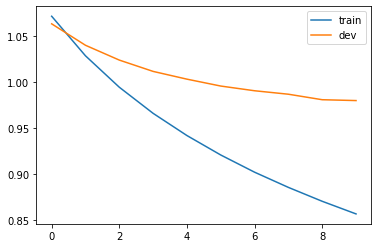

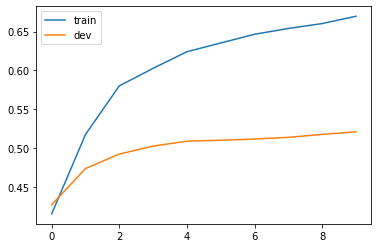

In [ ]:
plt.plot(train_loss, label='train')
plt.plot(dev_loss, label='dev')
plt.legend()
plt.show()
plt.plot(train_acc, label='train')
plt.plot(dev_acc, label='dev')
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.50      0.50      0.50      1777
           1       0.52      0.68      0.59      1838
           2       0.59      0.35      0.44      1448

    accuracy                           0.52      5063
   macro avg       0.53      0.51      0.51      5063
weighted avg       0.53      0.52      0.51      5063



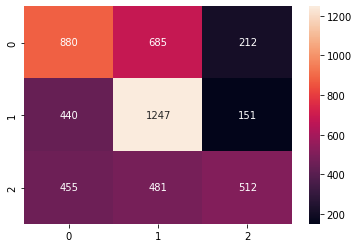

In [ ]:
y_true = []
y_pred = []
for i, (tfidf, sentiment) in enumerate(test_loader):
    tfidf = tfidf.to(device)
    sentiment = sentiment.to(device)
    outputs = model(tfidf)
    y_true.extend(sentiment.cpu().numpy())
    y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())
print(classification_report(y_true, y_pred))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
plt.show()

# SVM on TFIDF Vectors for Word2Vec

### We used the average of the word vectors in the sentence to represent the sentence and then trained a simple MLP to predict the sentiments. It is a very simple model but it gives a good enough accuracy.

In [ ]:
# build a dictionary where the keys are the words and the values are columns in the tfidf matrix corresponding to the words
tfidf_dict = {word: tfidf_processor.tfidf_matrix[:, i].toarray().squeeze(1) for i, word in enumerate(tfidf_processor.tfidf.get_feature_names_out())}
word_vectors = {word:[] for word in tfidf_dict.keys()}

In [ ]:
# create dataloaders for MSCTD_train, MSCTD_dev, MSCTD_test
MSCTD_train_loader = DataLoader(MSCTD_train, batch_size=32, shuffle=True)
MSCTD_dev_loader = DataLoader(MSCTD_dev, batch_size=32, shuffle=True)
MSCTD_test_loader = DataLoader(MSCTD_test, batch_size=32, shuffle=True)

In [ ]:
for i, (captions, _) in enumerate(MSCTD_train_loader):
    print(f'Processing batch {i+1}') if i % 50 == 0 else None
    for caption in captions:
        for word in caption.split():
            if word in tfidf_dict.keys():
                tfidf = tfidf_dict[word]
                pos = [(tfidf_dict[i], 1) for i in caption.split() if i != word and i in tfidf_dict.keys()]
                if len(pos) > 4:
                    neg = [(tfidf_dict[i], 0) for i in np.random.choice(list(tfidf_dict.keys()), len(pos)) if i not in caption.split()]
                    # create a shuffled numpy array of pos and neg
                    combined = pos + neg
                    random.shuffle(combined)
                    # fit a linearsvc model on the combined array
                    model = LinearSVC(max_iter=10000)
                    model.fit(np.array([x for x, _ in combined]), np.array([y for _, y in combined]))
                    # add the weights and bias to the word_vectors dictionary. e.g) if params are w and b then word_vectors[word] = [w.T, b].T
                    weights = np.concatenate((model.coef_.squeeze(0), model.intercept_))
                    if not word_vectors[word]:
                        word_vectors[word].append([weights, 1])
                    else:
                        word_vectors[word][0][0] += weights
                        word_vectors[word][0][1] += 1
            

Processing batch 1
Processing batch 51
Processing batch 101
Processing batch 151
Processing batch 201
Processing batch 251
Processing batch 301
Processing batch 351
Processing batch 401
Processing batch 451
Processing batch 501
Processing batch 551
Processing batch 601


In [ ]:
# average the weights and bias
len_of_weights = len(word_vectors['the'][0][0])
for word in word_vectors.keys():
    if len(word_vectors[word]) > 0:
        word_vectors[word][0] = word_vectors[word][0][0] / word_vectors[word][0][1]
    else:
        word_vectors[word].append(np.zeros(len_of_weights))

In [ ]:
# define a SVMEmbedding class
class SVMEmbedding:
    def __init__(self, embeddings):
        self.embeddings = embeddings
        self.dim = list(embeddings.values())[0][0].shape[0]
    def __call__(self, caption):
        # return the average of the word embeddings of the words in the caption
        words = caption.split()
        words = [word for word in words if word in self.embeddings.keys()]
        if len(words) == 0:
            return np.zeros(self.dim)
        else:
            return np.mean([self.embeddings[word][0] for word in words], axis=0)

# create a SVMEmbedding object
svm_embedding = SVMEmbedding(word_vectors)
# Test the SVMEmbedding object
print(svm_embedding('the cat is on the mat'))

[ 1.51647619e-04  7.93873313e-04  1.28596773e-03 ...  4.43881812e-04
  6.74582471e-05 -6.51240441e-01]


In [ ]:
class SVMDataset(Dataset):
    def __init__(self, dataset, embedding):
        self.dataset = dataset
        self.embedding = embedding
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        caption, sentiment = self.dataset[idx]
        embedding = self.embedding(caption)
        return embedding, sentiment

train_dataset = SVMDataset(MSCTD_train, svm_embedding)
dev_dataset = SVMDataset(MSCTD_dev, svm_embedding)
test_dataset = SVMDataset(MSCTD_test, svm_embedding)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [ ]:
input_size = len_of_weights
num_classes = 3
model = MLPClassifier(input_size, num_classes)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Train the model for 10 epochs
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []
for epoch in range(10):
    running_loss = 0.0
    running_acc = 0.0
    for i, (embedding, sentiment) in enumerate(train_loader):
        embedding = embedding.to(device)
        sentiment = sentiment.to(device)
        outputs = model(embedding.float())
        loss = loss_fn(outputs, sentiment)
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_acc += (torch.argmax(outputs, dim=1) == sentiment).sum().item()
    train_loss.append(running_loss / len(train_loader))
    train_acc.append(running_acc / len(train_loader.dataset))
    print(f'Epoch {epoch+1}/{10}, Training Loss: {train_loss[-1]:.4f}, Training Accuracy: {train_acc[-1]:.4f}')
    # Evaluate on the dev set
    with torch.no_grad():
        running_loss = 0.0
        running_acc = 0.0
        for i, (embedding, sentiment) in enumerate(dev_loader):
            embedding = embedding.to(device)
            sentiment = sentiment.to(device)
            outputs = model(embedding.float())
            loss = loss_fn(outputs, sentiment)
            running_loss += loss.item()
            running_acc += (torch.argmax(outputs, dim=1) == sentiment).sum().item()
        dev_loss.append(running_loss / len(dev_loader))
        dev_acc.append(running_acc / len(dev_loader.dataset))
        print(f'Epoch {epoch+1}/{10}, Dev Loss: {dev_loss[-1]:.4f}, Dev Accuracy: {dev_acc[-1]:.4f}')
        

Epoch 1/10, Training Loss: 1.0809, Training Accuracy: 0.4066
Epoch 1/10, Dev Loss: 1.0821, Dev Accuracy: 0.4071
Epoch 2/10, Training Loss: 1.0630, Training Accuracy: 0.4459
Epoch 2/10, Dev Loss: 1.0795, Dev Accuracy: 0.3915
Epoch 3/10, Training Loss: 1.0497, Training Accuracy: 0.4631
Epoch 3/10, Dev Loss: 1.0734, Dev Accuracy: 0.4138
Epoch 4/10, Training Loss: 1.0386, Training Accuracy: 0.4770
Epoch 4/10, Dev Loss: 1.0634, Dev Accuracy: 0.4391
Epoch 5/10, Training Loss: 1.0290, Training Accuracy: 0.4896
Epoch 5/10, Dev Loss: 1.0624, Dev Accuracy: 0.4420
Epoch 6/10, Training Loss: 1.0206, Training Accuracy: 0.4956
Epoch 6/10, Dev Loss: 1.0564, Dev Accuracy: 0.4507
Epoch 7/10, Training Loss: 1.0127, Training Accuracy: 0.5075
Epoch 7/10, Dev Loss: 1.0562, Dev Accuracy: 0.4408
Epoch 8/10, Training Loss: 1.0064, Training Accuracy: 0.5116
Epoch 8/10, Dev Loss: 1.0499, Dev Accuracy: 0.4626
Epoch 9/10, Training Loss: 0.9997, Training Accuracy: 0.5198
Epoch 9/10, Dev Loss: 1.0508, Dev Accuracy:

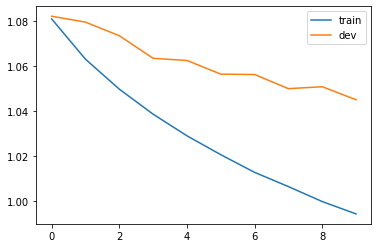

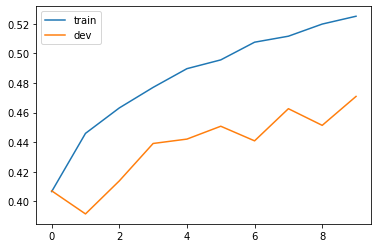

In [ ]:
plt.plot(train_loss, label='train')
plt.plot(dev_loss, label='dev')
plt.legend()
plt.show()
plt.plot(train_acc, label='train')
plt.plot(dev_acc, label='dev')
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.36      0.51      0.42      1298
           1       0.54      0.69      0.60      2163
           2       0.63      0.18      0.28      1606

    accuracy                           0.48      5067
   macro avg       0.51      0.46      0.43      5067
weighted avg       0.52      0.48      0.45      5067



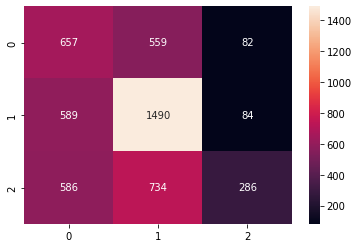

In [ ]:
# confusion matrix and classification report
y_pred = []
y_true = []
with torch.no_grad():
    for i, (embedding, sentiment) in enumerate(test_loader):
        embedding = embedding.to(device)
        sentiment = sentiment.to(device)
        outputs = model(embedding.float())
        y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        y_true.extend(sentiment.cpu().numpy())
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
print(classification_report(y_true, y_pred))

# GloVe 

### We used the average of the word vectors in the sentence to represent the sentence and then trained a simple MLP to predict the sentiments. It is a very simple model but it gives a good enough accuracy.

In [ ]:
# download glove embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-02-06 11:36:38--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-02-06 11:36:38--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-02-06 11:36:39--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
glove_embeddings = {}
with open('glove.6B.50d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], 'float32')
        glove_embeddings[word] = vector

class GloveEmbedding:
    def __init__(self, embeddings):
        self.embeddings = embeddings
        self.dim = list(embeddings.values())[0].shape[0]
        
    def __call__(self, caption):
        words = caption.split()
        vectors = [self.embeddings.get(word, np.zeros(self.dim)) for word in words]
        if len(vectors) == 0:
            return np.zeros(self.dim)
        return np.mean(vectors, axis=0)

glove_embedding = GloveEmbedding(glove_embeddings)

In [ ]:
class GloveDataSet(Dataset):
    def __init__(self, dataset, embedding):
        self.dataset = dataset
        self.embedding = embedding
        
    def __getitem__(self, index):
        caption, sentiment = self.dataset[index]
        embedding = self.embedding(caption)
        return torch.from_numpy(embedding.astype(np.float32)), torch.from_numpy(np.array(sentiment))

    def __len__(self):
        return len(self.dataset)

In [ ]:
# create datasets
train_dataset = GloveDataSet(MSCTD_train, glove_embedding)
dev_dataset = GloveDataSet(MSCTD_dev, glove_embedding)
test_dataset = GloveDataSet(MSCTD_test, glove_embedding)

In [ ]:
# create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [ ]:
input_size = 50
num_classes = 3
model = MLPClassifier(input_size, num_classes)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Train the model for 10 epochs
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []
for epoch in range(10):
    running_loss = 0.0
    running_acc = 0.0
    for i, (embedding, sentiment) in enumerate(train_loader):
        embedding = embedding.to(device)
        sentiment = sentiment.to(device)
        
        outputs = model(embedding)
        loss = loss_fn(outputs, sentiment)
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_acc += (torch.argmax(outputs, dim=1) == sentiment).sum().item()
    train_loss.append(running_loss / len(train_loader))
    train_acc.append(running_acc / len(train_loader.dataset))
    print(f'Epoch {epoch+1}/{10}, Training Loss: {train_loss[-1]:.4f}, Training Accuracy: {train_acc[-1]:.4f}')
    # Evaluate on the dev set
    with torch.no_grad():
        running_loss = 0.0
        running_acc = 0.0
        for i, (embedding, sentiment) in enumerate(dev_loader):
            embedding = embedding.to(device)
            sentiment = sentiment.to(device)
            outputs = model(embedding)
            loss = loss_fn(outputs, sentiment)
            running_loss += loss.item()
            running_acc += (torch.argmax(outputs, dim=1) == sentiment).sum().item()
        dev_loss.append(running_loss / len(dev_loader))
        dev_acc.append(running_acc / len(dev_loader.dataset))
        print(f'Epoch {epoch+1}/{10}, Dev Loss: {dev_loss[-1]:.4f}, Dev Accuracy: {dev_acc[-1]:.4f}')
        

Epoch 1/10, Training Loss: 1.0695, Training Accuracy: 0.4338
Epoch 1/10, Dev Loss: 1.0538, Dev Accuracy: 0.4385
Epoch 2/10, Training Loss: 1.0332, Training Accuracy: 0.4810
Epoch 2/10, Dev Loss: 1.0313, Dev Accuracy: 0.4782
Epoch 3/10, Training Loss: 1.0199, Training Accuracy: 0.4960
Epoch 3/10, Dev Loss: 1.0246, Dev Accuracy: 0.4825
Epoch 4/10, Training Loss: 1.0138, Training Accuracy: 0.5005
Epoch 4/10, Dev Loss: 1.0211, Dev Accuracy: 0.4914
Epoch 5/10, Training Loss: 1.0100, Training Accuracy: 0.5044
Epoch 5/10, Dev Loss: 1.0185, Dev Accuracy: 0.4898
Epoch 6/10, Training Loss: 1.0078, Training Accuracy: 0.5064
Epoch 6/10, Dev Loss: 1.0149, Dev Accuracy: 0.4997
Epoch 7/10, Training Loss: 1.0062, Training Accuracy: 0.5087
Epoch 7/10, Dev Loss: 1.0125, Dev Accuracy: 0.4989
Epoch 8/10, Training Loss: 1.0054, Training Accuracy: 0.5082
Epoch 8/10, Dev Loss: 1.0141, Dev Accuracy: 0.4969
Epoch 9/10, Training Loss: 1.0038, Training Accuracy: 0.5073
Epoch 9/10, Dev Loss: 1.0141, Dev Accuracy:

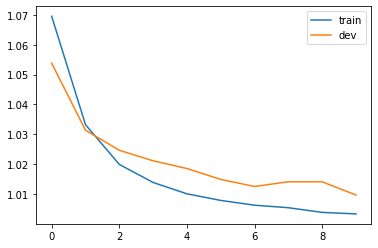

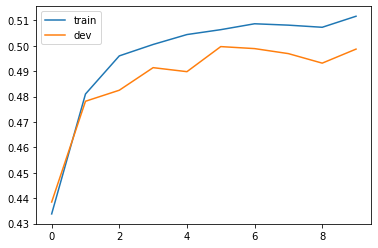

In [ ]:
plt.plot(train_loss, label='train')
plt.plot(dev_loss, label='dev')
plt.legend()
plt.show()
plt.plot(train_acc, label='train')
plt.plot(dev_acc, label='dev')
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.38      0.47      0.42      1298
           1       0.56      0.63      0.60      2163
           2       0.56      0.35      0.43      1606

    accuracy                           0.50      5067
   macro avg       0.50      0.49      0.48      5067
weighted avg       0.52      0.50      0.50      5067



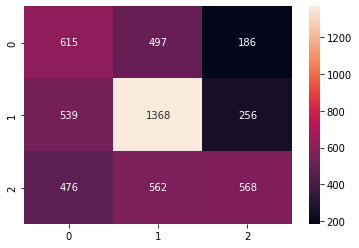

In [ ]:
# confusion matrix and classification report
y_pred = []
y_true = []
with torch.no_grad():
    for i, (embedding, sentiment) in enumerate(test_loader):
        embedding = embedding.to(device)
        sentiment = sentiment.to(device)
        outputs = model(embedding)
        y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        y_true.extend(sentiment.cpu().numpy())
print(classification_report(y_true, y_pred),)
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')


# BERT Classifier

### In this part we used the bert tokenizer to tokenize words and pad them to max length and then fed the data to the freezed bert model and added a linear layer on top of it to predict the sentiment.

In [ ]:
# define a class that get a dataset and return tokenized dataset
class TokenizedDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=80):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __getitem__(self, index):
        text, sentiment = self.dataset[index]
        text = self.tokenizer.encode_plus(text, add_special_tokens=True, max_length=self.max_length, 
                                          padding='max_length', truncation=True, return_tensors='pt')
        return text, sentiment
    def __len__(self):
        return len(self.dataset)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# tokenize datasets
max_length = 25
tokenized_train = TokenizedDataset(MSCTD_train, tokenizer, max_length)
tokenized_dev = TokenizedDataset(MSCTD_dev, tokenizer, max_length)
tokenized_test = TokenizedDataset(MSCTD_test, tokenizer, max_length)
# dataloader
train_dataloader_tokenized = DataLoader(tokenized_train, batch_size=32, shuffle=True)
dev_dataloader_tokenized = DataLoader(tokenized_dev, batch_size=32, shuffle=True)
test_dataloader_tokenized = DataLoader(tokenized_test, batch_size=32, shuffle=True)

In [ ]:
bert = BertModel.from_pretrained('bert-base-uncased')
# freeze bert parameters
for param in bert.parameters():
    param.requires_grad = False
# create a new classifier from bert to classify sentiment
class BertClassifier(nn.Module):
    def __init__(self, bert, num_classes):
        super(BertClassifier, self).__init__()
        self.bert = bert
        self.linear = nn.Linear(768, num_classes)
    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        output = self.linear(output[1])
        return output

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs, device):
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    model = model.to(device)
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(input_ids=inputs['input_ids'].squeeze(1).to(device), attention_mask=inputs['attention_mask'].to(device))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (outputs.argmax(1) == labels).sum().item()
        train_loss /= len(train_loader)
        train_acc /= len(train_loader.dataset)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        print(f'Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    return train_losses, train_accs, val_losses, val_accs

def evaluate(model, val_loader, criterion, device):
    model = model.to(device)
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(input_ids=inputs['input_ids'].squeeze(1).to(device), attention_mask=inputs['attention_mask'].to(device))
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.argmax(1) == labels).sum().item()
    val_loss /= len(val_loader)
    val_acc /= len(val_loader.dataset)
    return val_loss, val_acc

In [ ]:
model = BertClassifier(bert, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_losses, train_accs, val_losses, val_accs = train(model, train_dataloader_tokenized, dev_dataloader_tokenized, optimizer, criterion, epochs, device)

Epoch: 1/10, Train Loss: 1.0445, Train Acc: 0.4535, Val Loss: 1.0116, Val Acc: 0.5173
Epoch: 2/10, Train Loss: 0.9961, Train Acc: 0.5108, Val Loss: 0.9865, Val Acc: 0.5116
Epoch: 3/10, Train Loss: 0.9824, Train Acc: 0.5246, Val Loss: 0.9773, Val Acc: 0.5177
Epoch: 4/10, Train Loss: 0.9702, Train Acc: 0.5353, Val Loss: 0.9728, Val Acc: 0.5489
Epoch: 5/10, Train Loss: 0.9641, Train Acc: 0.5383, Val Loss: 0.9482, Val Acc: 0.5489
Epoch: 6/10, Train Loss: 0.9602, Train Acc: 0.5482, Val Loss: 0.9517, Val Acc: 0.5509
Epoch: 7/10, Train Loss: 0.9553, Train Acc: 0.5457, Val Loss: 0.9454, Val Acc: 0.5564
Epoch: 8/10, Train Loss: 0.9506, Train Acc: 0.5485, Val Loss: 0.9635, Val Acc: 0.5443
Epoch: 9/10, Train Loss: 0.9534, Train Acc: 0.5479, Val Loss: 0.9373, Val Acc: 0.5526
Epoch: 10/10, Train Loss: 0.9507, Train Acc: 0.5516, Val Loss: 0.9506, Val Acc: 0.5574


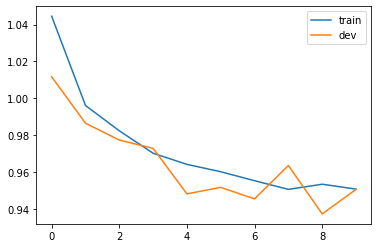

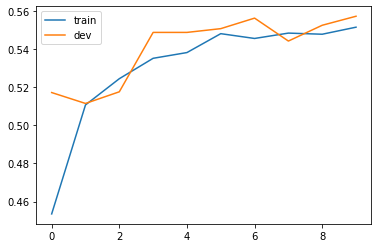

In [ ]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='dev')
plt.legend()
plt.show()
plt.plot(train_accs, label='train')
plt.plot(val_accs, label='dev')
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.45      0.44      0.45      1298
           1       0.63      0.70      0.66      2163
           2       0.59      0.51      0.55      1606

    accuracy                           0.57      5067
   macro avg       0.56      0.55      0.55      5067
weighted avg       0.57      0.57      0.57      5067



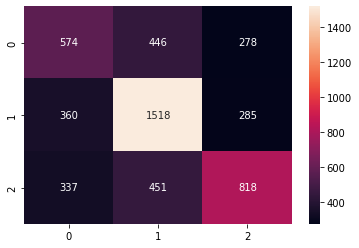

In [ ]:
y_pred = []
y_true = []
with torch.no_grad():
    for i, (inputs, sentiment) in enumerate(test_dataloader_tokenized):
        inputs = inputs.to(device)
        sentiment = sentiment.to(device)
        outputs = model(input_ids=inputs['input_ids'].squeeze(1).to(device), attention_mask=inputs['attention_mask'].to(device))
        y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        y_true.extend(sentiment.cpu().numpy())
print(classification_report(y_true, y_pred))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
plt.show()

### We got a very better result than using sentence embedding. We now try to fine-tune the Bert model 

In [ ]:
# Fine-tune the whole model
bert = BertModel.from_pretrained('bert-base-uncased')
gc.collect()
torch.cuda.empty_cache()
model = BertClassifier(bert, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_losses, train_accs, val_losses, val_accs = train(model, train_dataloader_tokenized, dev_dataloader_tokenized, optimizer, criterion, 2, device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 1/2, Train Loss: 0.8841, Train Acc: 0.5993, Val Loss: 0.8682, Val Acc: 0.5985
Epoch: 2/2, Train Loss: 0.7176, Train Acc: 0.6994, Val Loss: 0.9768, Val Acc: 0.5917


              precision    recall  f1-score   support

           0       0.46      0.50      0.48      1298
           1       0.68      0.71      0.70      2163
           2       0.63      0.55      0.59      1606

    accuracy                           0.61      5067
   macro avg       0.59      0.59      0.59      5067
weighted avg       0.61      0.61      0.61      5067



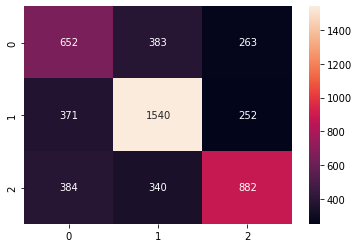

In [ ]:
y_pred = []
y_true = []
with torch.no_grad():
    for i, (inputs, sentiment) in enumerate(test_dataloader_tokenized):
        inputs = inputs.to(device)
        sentiment = sentiment.to(device)
        outputs = model(input_ids=inputs['input_ids'].squeeze(1).to(device), attention_mask=inputs['attention_mask'].to(device))
        y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        y_true.extend(sentiment.cpu().numpy())
print(classification_report(y_true, y_pred))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
plt.show()

### Lastly we used the bert tokenizer to tokenize words and pad them to max length and then fine-tuned the bert model and added a linear layer on top of it to predict the sentiment. We used the AdamW optimizer and the CrossEntropyLoss function. We trained the model for 2 epochs and got a good accuracy. 

* By comparing different models, we found that the BERT model with fine-tuning gives the best accuracy.
* We also found out that word embedding worked better than sentence embedding. 
* The word vectors resulted from training SVM on words didn't work well compared to the word vectors resulted from GloVe and BERT.
* The confusion matrix also shows that the model is much better at predicting the 2nd sentiment than others